# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

**Description:** En esta notebook realizaremos un experimento sobre el *problema del bandido de k brazos* con el que pretendemos comparar el desempeño de distintos algoritmos de la familia *UCB2* y *Softmax* en base a estadísticos como el porcentaje de elecciones de brazo óptimas y el *regret* acumulado en función del tiempo.

Para poder interpretar los resultados, se incluyen unas gráficas con sus respectivos análisis y conclusiones al final de la sección **[2]** y **[3]**.

<br>

*This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.*

*For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html*



## **[1] - Preparación del entorno**


In [10]:
#@title **Copiar el repositorio** ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

fatal: destination path 'k_brazos_GGM' already exists and is not an empty directory.


In [11]:
#@title **Importamos todas las clases y funciones**

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

from algorithms import Algorithm, UCB2, Softmax, AdaptiveSoftmax
from arms import ArmNormal, Bandit, ArmBinomial, ArmBernoulli
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **[2] - Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan varios algoritmos UCB2 y Softmax con diferentes valores de $\tau$. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [12]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualziamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    #proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    #proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, cumulative_regret_per_algo, rewards_per_arm

### **[2.1] - Ejecución del experimento con Distribución Normal**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB2 y 6 algoritmos Softmax con $\tau = 0.1, 0.2, 0.3, 0.5, 0.7, 0.9$.

In [13]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB2 y 6 algoritmos SOFTMAX con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.2), UCB2(k=k, alpha = 0.3),
              Softmax(k=k, tau = 0.1), Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1),
              AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.00001)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### **Visualización de los resultados**

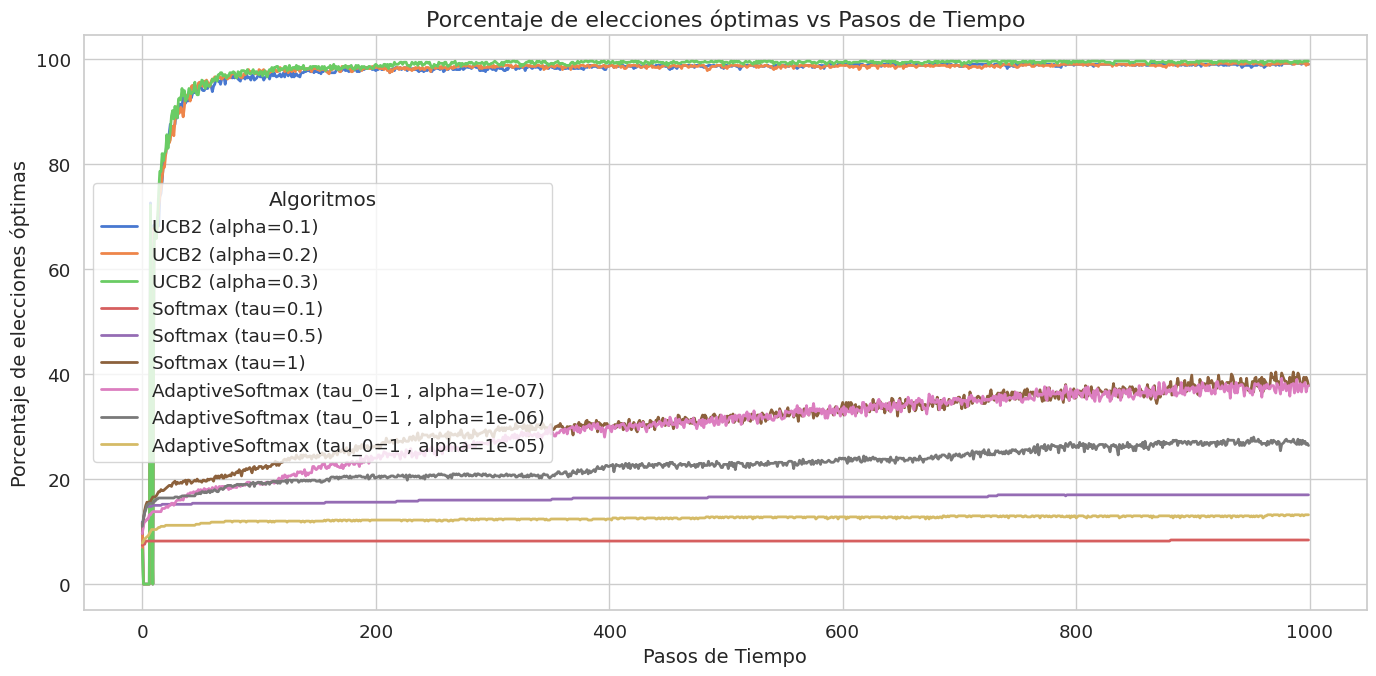

In [14]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB2 y Softmax consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB2 (línea **azul**) muestra un crecimiento del porcentaje de elecciones óptimas mucho más rápido que los algoritmos Softmax. Además, al cabo de un corto tiempo, consigue alcanzar valores muy elevados, cercanos al $100\%$. Es el algoritmo que mejores resultados obtiene.
  
  -Softmax asigna probabilidadesa las acciones en función de sus recompensas estimadas, lo que puede llevar a expliraciones excesivas o insuficientes dependiendo del valor de **$\tau$** **(tau)**.
  -**$\tau$** **bajo (0.1 - 0.3)** $\rightarrow$ Tiende a explotar demasiado, eligiendo la acción que parece mejor sin suficiente explotación.
  -**$\tau$** **alto (0.7 - 0.9)** $\rightarrow$ Explora demasiado, escogiendo muchas acciones subíptimas.
  
Esta diferencia entre el rendimiento de los algoritmos UCB2 y Softmax podría deberse a que UCB2 aquilibra exploración y explitación de manera más eficiente priorizando las acciones que han mostrado buenos resultados sin dejar de explar ocasionalmente.

  - Todas las variantes de Softmax alcanzan un porcentaje de elecciones mucho más bajas.
  - La mejor versión parece ser **Softmax** con **$\tau=0.5$** (linea **rosada**), pero aún así que muy lejos de UCB2.

UCB2 mejora esa estrategia gracias a la fórmula:


$$ UCB2(a) = Q(a) + \sqrt{\frac{(1+\alpha)\ln \left(\frac{t}{\tau (k_a)}\right)}{2\tau(k_a)}}$$

donde $Q(a)$ es la estimación del valor de la acción $a$, $0<\alpha<1$ es un parámetro de ajuste para el balance entre exploración y explotación, $k_a$ es el número de épocas de la acción $a$, y $\tau(k_a) = \lceil (1+\alpha)^{k_a}\rceil$ determina el número de veces que la acción $a$ será seleccionada en un época.
  
Sin embargo, el algoritmo Softmax mejora esta estrategia gracias a la fórmula:

$$ Softmax(z_i) = \frac {e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$

donde
- $z_i$ es la lógica (la salida de la capa anterior de la red)
- **K** es el número de clases
- ${\sum_{j=1}^K e^{z_j}}$ suma de exponenciales a través de todas las clases.

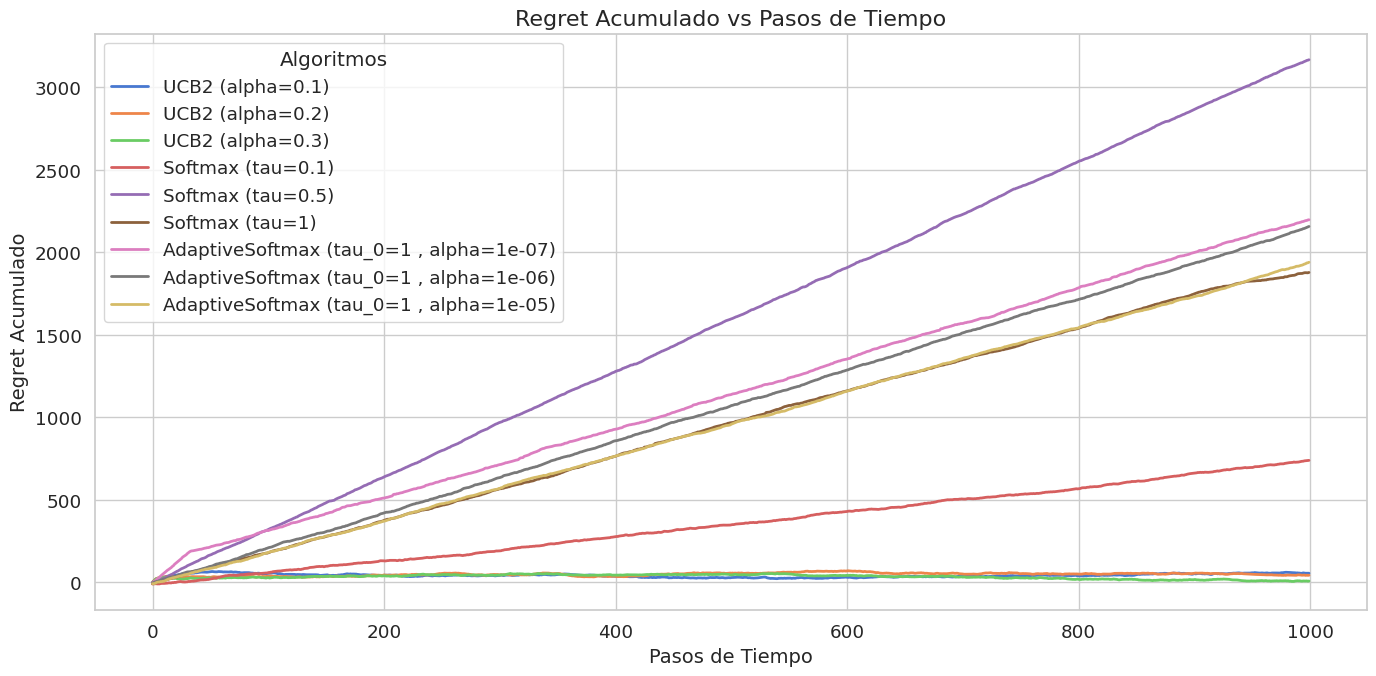

In [15]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB1** y Softmax considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo UCB2 (línea **azul**) muestra un buen desempeño, pues se observa que el regret acumulado a lo largo del tiempo se mantiene muy cerca del $0$. Esto seguramente sea debido a la estrategia dinámica de balanceo entre exploración y explotación del algoritmo UCB1.
  - Los algoritmos Softmax con **$\tau=0.2,0.3$** (líneas **verde, marron**), muestran el mejor desempeño, siendo el **verde** el mejor ya que el **regret** acumulado a lo largo del tiempo es **$0$**, dicho algoritmo consigue descubrir rápidamente el brazo óptimo.
  -El algoritmo Softmax con **$\tau=0.7$** comienza bastante bien, con un regret relativamente lento, pero a lo largo del tiempo, su desempeño se va empeorando hasta alcanzar un regret de casi cerca de $2$.
  
  - El algoritmo Softmax con **$\tau=0.1$** (Línea **naranja**) muestra el peor desepeño, pues el regret crece de forma lineal con el tiempo, con valores mucho mayores que los otros algortimos. Esto confirma que seguir una estrategia puramente de explotación, sin nada de exploración, lleva a que el algoritmo se quede atrapado en el primer brazo escogido, que puede no ser el óptimo.

En esta ocasión se ve que segun que valores de **$\tau$** se utilice, el algoritmo Softmax podría funcionar mejor de el UCB1.

Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \frac{(\mu_i - \mu^*)^2}{2\sigma^2}$

In [16]:
def I_normal(mu_i, mu_star, sigma_2):
    """Divergencia KL entre dos normales con la misma varianza."""
    return (mu_i - mu_star)**2 / (2 * sigma_2)

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
sigma_2 = 1          # Varianza de los brazos (igual para todos)

# Calcular la constante
cte = sum((mu_star - mu) / I_normal(mu, mu_star, sigma_2) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-16-e8a6397acd45>:13: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


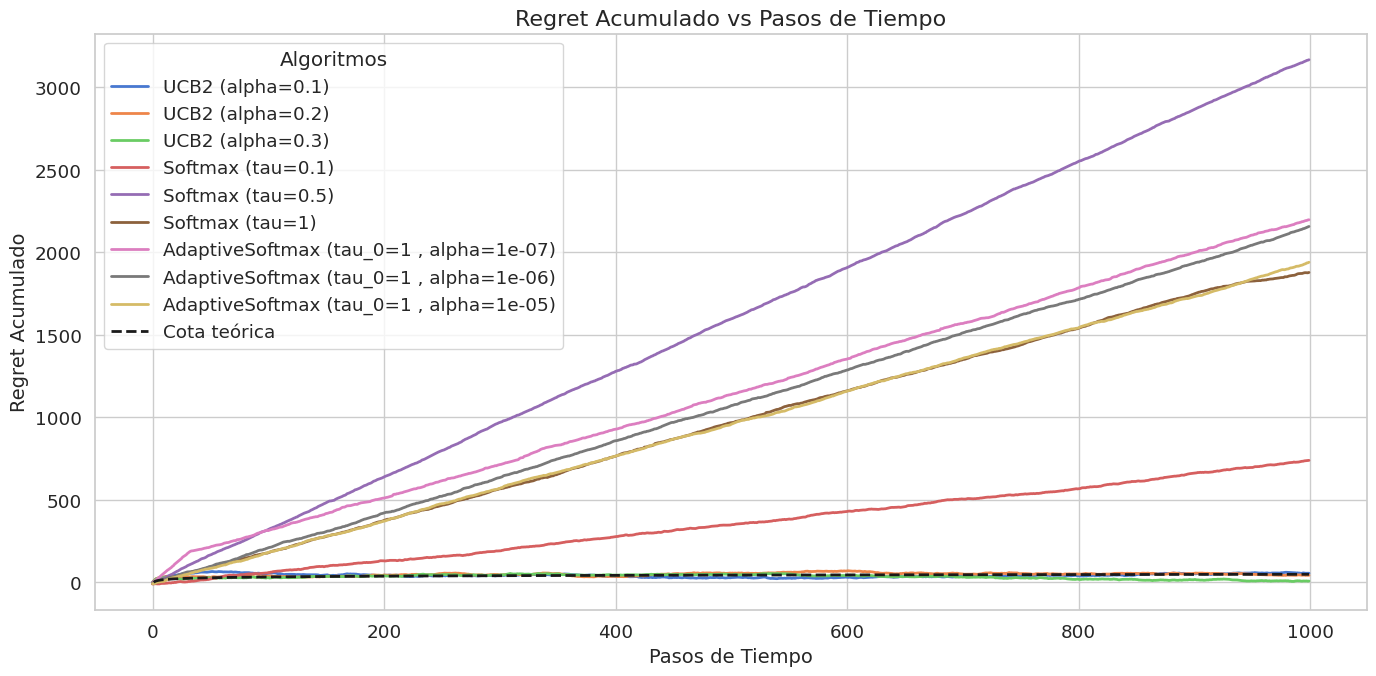

In [17]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

Efectivamente, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos UCB considerados, mostrando el buen desempeño de dichos algoritmos.

### **[2.2] - Ejecución del experimento con Distribución Bernoulli**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB2 y 6 algoritmos Softmax con $\tau = 0.1, 0.2, 0.3, 0.5, 0.7, 0.9$.

In [18]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k))    # Generar un bandido con k brazos de distribución Bernoulli
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB2 y 6 algoritmos SOFTMAX con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.2), UCB2(k=k, alpha = 0.3),
              Softmax(k=k, tau = 0.1), Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1),
              AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.00001)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBernoulli(p=0.3745401188473625), ArmBernoulli(p=0.9507143064099162), ArmBernoulli(p=0.7319939418114051), ArmBernoulli(p=0.5986584841970366), ArmBernoulli(p=0.15601864044243652), ArmBernoulli(p=0.15599452033620265), ArmBernoulli(p=0.05808361216819946), ArmBernoulli(p=0.8661761457749352), ArmBernoulli(p=0.6011150117432088), ArmBernoulli(p=0.7080725777960455)
Optimal arm: 2 with expected reward=0.9507143064099162


#### **Visualización de los resultados**

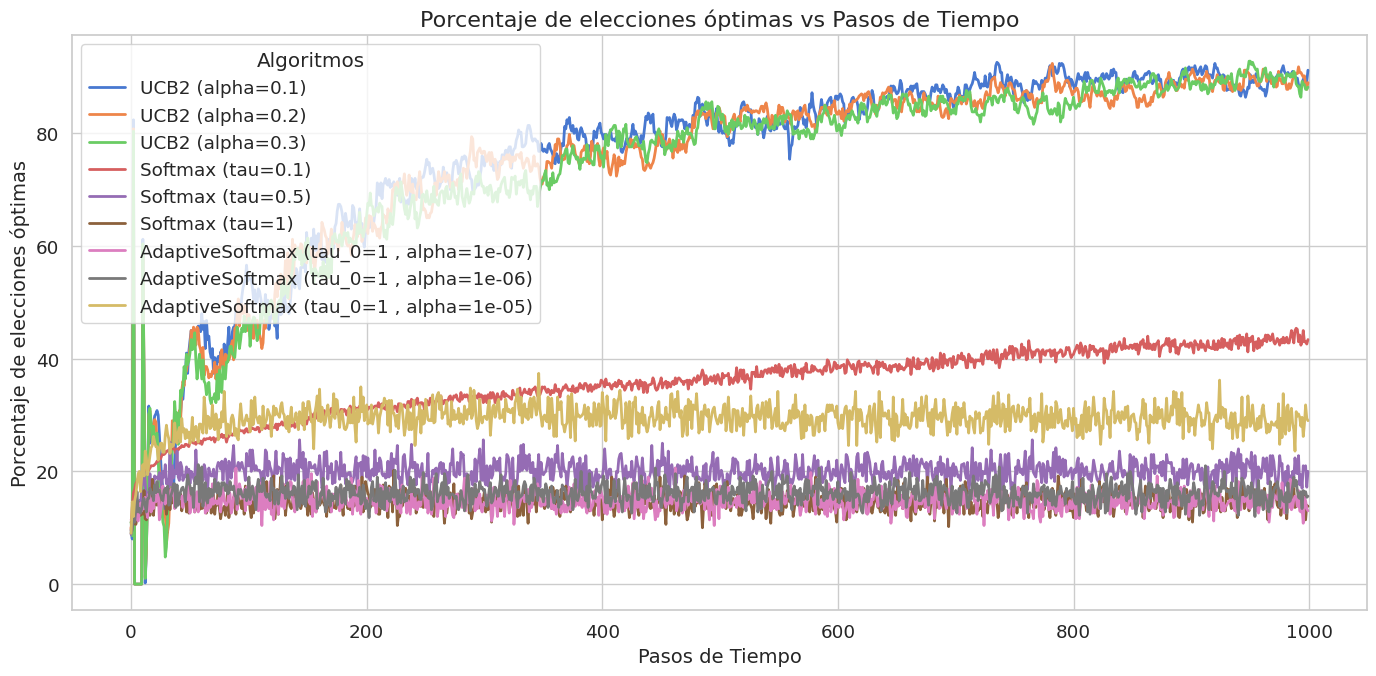

In [19]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB2 y Softmax consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB2 (línea **azul**) alcanza mucho más rápido un porcentaje de elecciones óptimas alto, lo que implica una estrategia con mayor exploración.

  - Los algoritmos Softmx con **$\tau=0.3,0.5,0.7,0.9$** (Lineas **roja,marrón y morado**) difieren muy poco entre si con un porcentaje de elecciones óptimas bastante bajo

  Los algoritmos Softmx con **$\tau=0.1,0.2$** (Lineas **naranja y verde,morada**) difieren muy poco entre si superando al resto de la familia Softmax, siendo la linea naranja la mejor, aunque ambos quedandose muy por debajo del UCB2 con un porcentaje de elecciones óptimas bastante bajo.


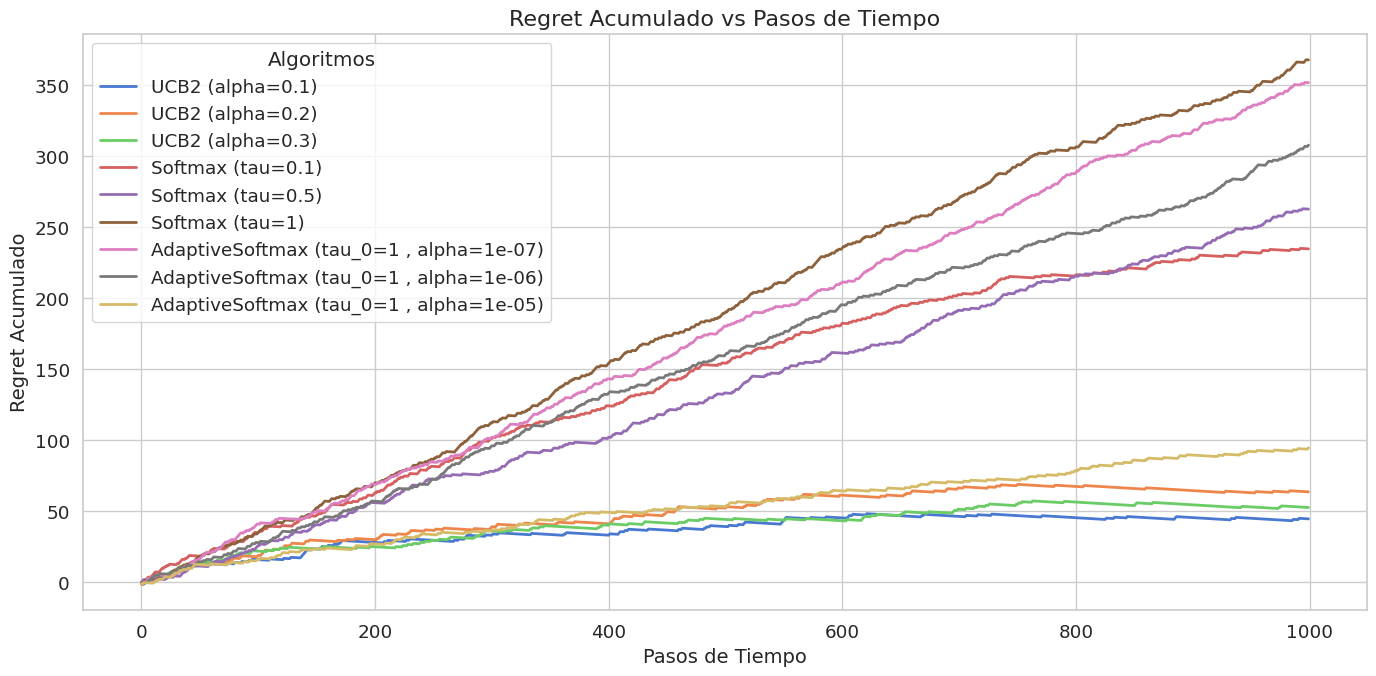

In [20]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB2, Softmax** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo UCB2 (línea **azul**)  muestra el mejor desempeño junto con el Softmax con **$\tau=0.1$** (linea **naranja**) de todos para el regret acumulado, probablemente debido a que balancean mejor de forma más eficiente exploración y explotación.

  - Los algoritmos Softmax con **$\tau=0.5,0.7 y 0.9$** (líneas **marrón, rosa y morado**) muestran el peor desempeño para el regret acumulado con el paso del tiempo debido probablemente a una poca eficiencia en el balanceo entre explotación y exploración.


Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \mu_i \ln \left( \frac{\mu_i}{\mu^*} \right) + (1 - \mu_i) \ln \left( \frac{1 - \mu_i}{1 - \mu^*} \right)$

In [21]:
def I_bernoulli(mu_i, mu_star):
    """Divergencia KL entre dos Bernoulli."""
    return mu_i * np.log(mu_i / mu_star) + (1 - mu_i) * np.log((1 - mu_i) / (1 - mu_star))

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo

# Calcular la constante
cte = sum((mu_star - mu) / I_bernoulli(mu, mu_star) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-21-14c133996bdd>:12: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


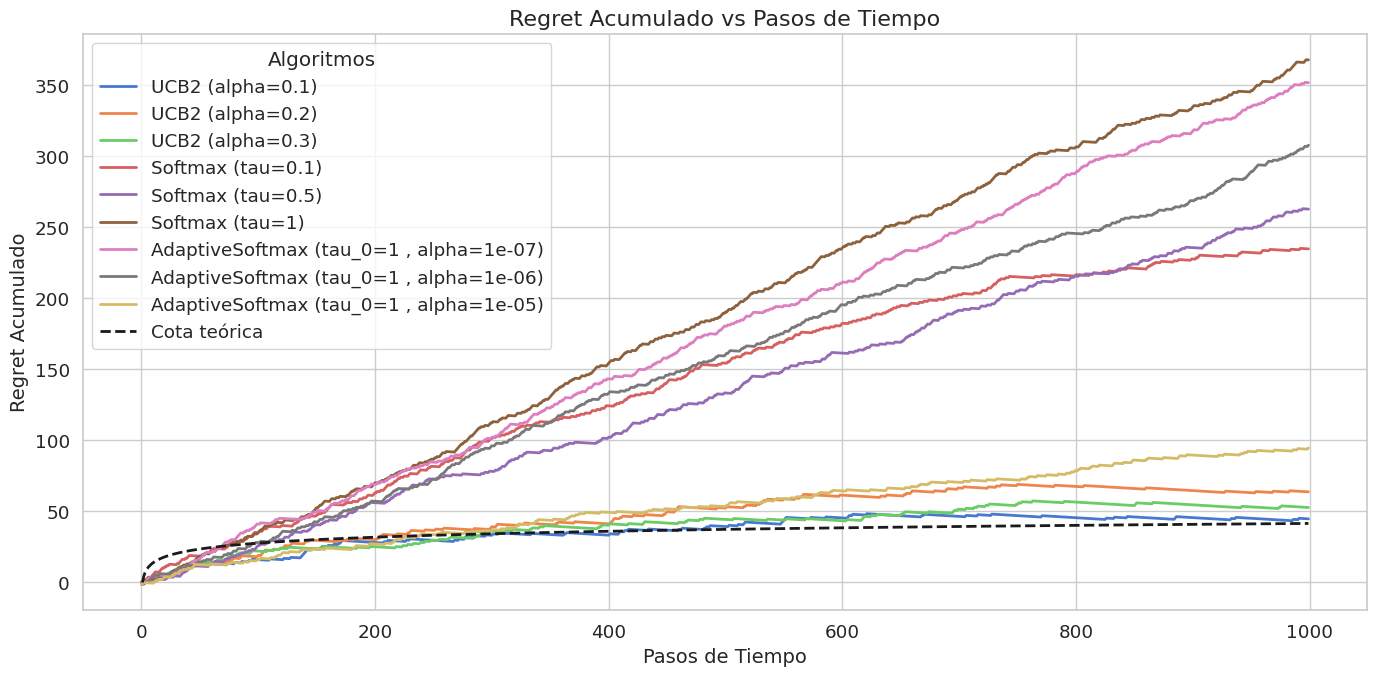

In [22]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

De nuevo, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos UCB considerados, mostrando el buen desempeño de dichos algoritmos.

### **[2.3] - Ejecución del experimento con Distribución Binomial**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB2 y 6 algoritmos Softmax con $\tau = 0.1, 0.2, 0.3, 0.5, 0.7, 0.9$.

In [23]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k))    # Generar un bandido con k brazos de distribución Binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB1 y 6 algoritmos SOFTMAX con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.2), UCB2(k=k, alpha = 0.3),
              Softmax(k=k, tau = 0.1), Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1),
              AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.00001)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBinomial(n=20, p=0.21233911067827616), ArmBinomial(n=2, p=0.8661761457749352), ArmBinomial(n=9, p=0.9507143064099162), ArmBinomial(n=8, p=0.5247564316322378), ArmBinomial(n=5, p=0.18340450985343382), ArmBinomial(n=15, p=0.7080725777960455), ArmBinomial(n=1, p=0.9699098521619943), ArmBinomial(n=11, p=0.2912291401980419), ArmBinomial(n=18, p=0.5986584841970366), ArmBinomial(n=4, p=0.15599452033620265)
Optimal arm: 9 with expected reward=10.775852715546659


#### **Visualización de los resultados**

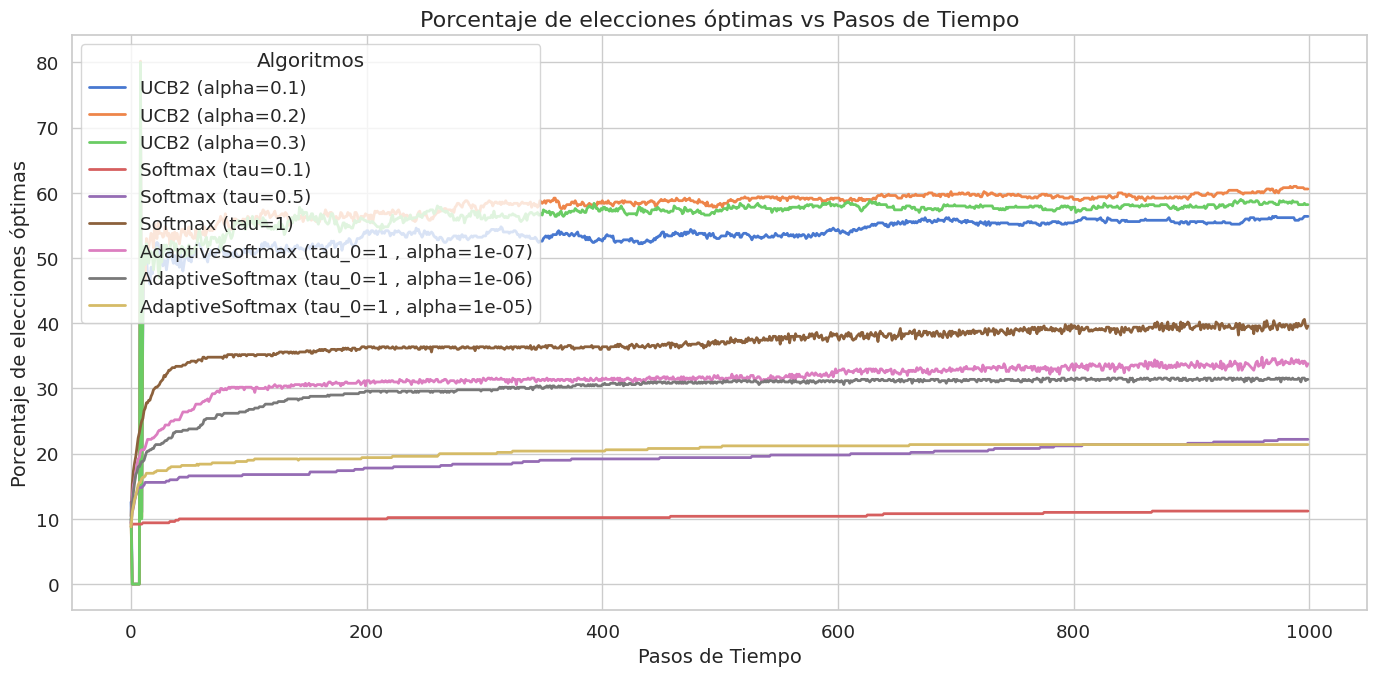

In [24]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB2 y Softmax consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB2 (línea **azul**) muestra el mejor desempeño en términos de elecciones óptimas. Esto puede deberse a que con distribución normal, la incertidumbre en la probabilidad de éxito es significativa en las primeras etapas, y el algoritmo se ajusta gradualmente conforme va adquiriendo experiencia.
  - Los algoritmos Softmax con **$\tau=0.7, 0.9$** (líneas **rosa y marrón**), muestran un desempeño parecido pero quedándose muy por debajo de UCB2
  
  - Se ve bastante casi igualados los algoritmos Softmax con **$\tau=0.1, 0.2, 0.3, 0.5$** en términos de elecciones óptimass. Se observa que en una distribución binomial, favorecer la explotación desde el principio con un $\tau$ bajo puede no ser efectivo al principio, porque el algoritmo puede no tener suficiente información para tomar decisiones óptimas rápidamente.

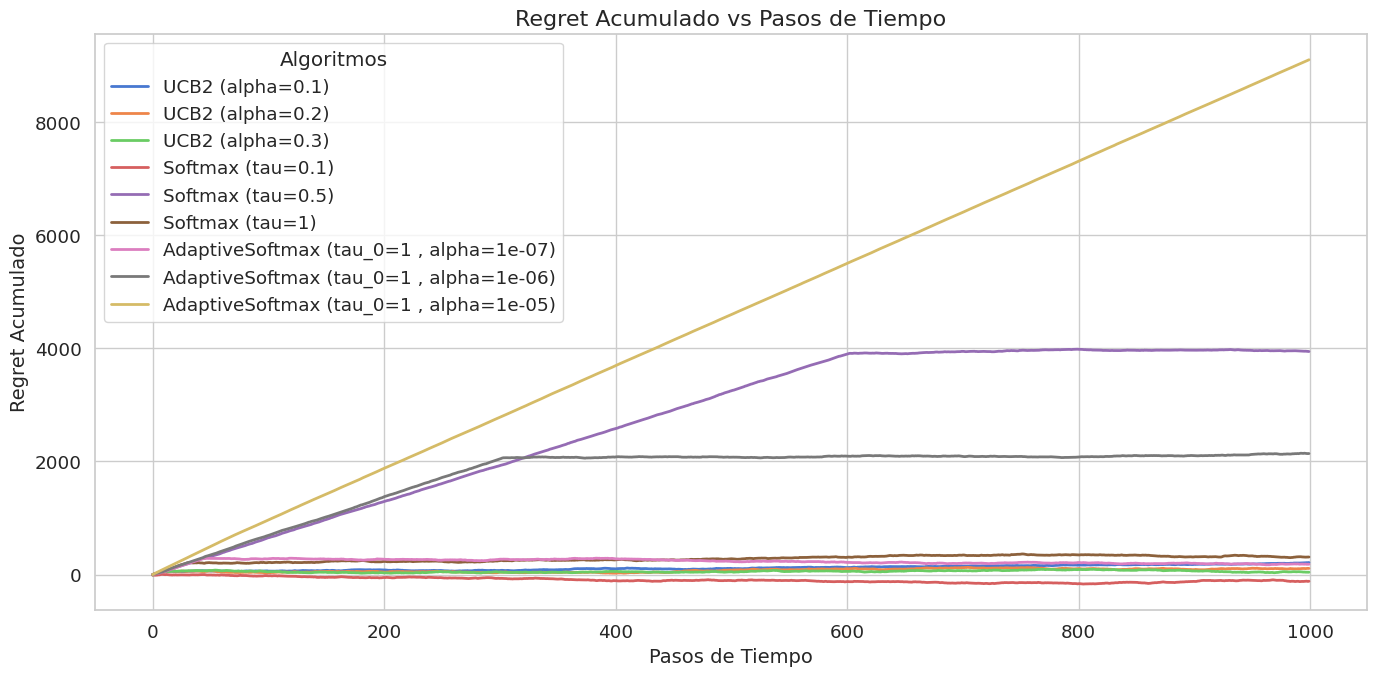

In [25]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB2 y Softmax** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo UCB2 (línea **azul**) junto con los algoritmos Softmax con **$\tau=0.1, 0.2$** (lineas **naranja y verde**) muestran el mejor desempeño de todos para el regret acumulado, probablemente debido a que son capaz de balancear de forma más eficiente que el resto la explotación y exploración.

  Se observa que el **regret** acumulado crece a mdida que aumenta el **$\tau$ç** hasta que se estabiliza, mientras que al alcanzar un **$\tau$** de 0.9 o superior no parece que se vata a estabilizar nunca.


Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución binomial: $I(p_i, p^*) = n_i \left[ p_i \ln \left( \frac{p_i}{p^*} \right) + (1 - p_i) \ln \left( \frac{1 - p_i}{1 - p^*} \right) \right] + n^* \left[ p^* \ln \left( \frac{p^*}{p_i} \right) + (1 - p^*) \ln \left( \frac{1 - p^*}{1 - p_i} \right) \right]$

In [26]:
def I_binomial(n_i, n_star, p_i, p_star):
    """Divergencia KL entre dos Binomiales B(n_i, p_i) y B(n_star, p_star)."""
    term1 = n_i * (p_i * np.log(p_i / p_star) + (1 - p_i) * np.log((1 - p_i) / (1 - p_star)))
    term2 = n_star * (p_star * np.log(p_star / p_i) + (1 - p_star) * np.log((1 - p_star) / (1 - p_i)))

    return term1 + term2

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
ns = [arm.n for arm in bandit.arms]
n_star = max(ns)
ps = [arm.p for arm in bandit.arms]
p_star = max(ps)

# Calcular la constante
cte = sum((mu_star - mus[i]) / I_binomial(ns[i], n_star, ps[i], p_star) for i in range(len(mus)) if mus[i] < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-26-909619a28c65>:16: RuntimeWarning: divide by zero encountered in scalar divide
  cte = sum((mu_star - mus[i]) / I_binomial(ns[i], n_star, ps[i], p_star) for i in range(len(mus)) if mus[i] < mu_star)
<ipython-input-26-909619a28c65>:19: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])
<ipython-input-26-909619a28c65>:19: RuntimeWarning: invalid value encountered in multiply
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


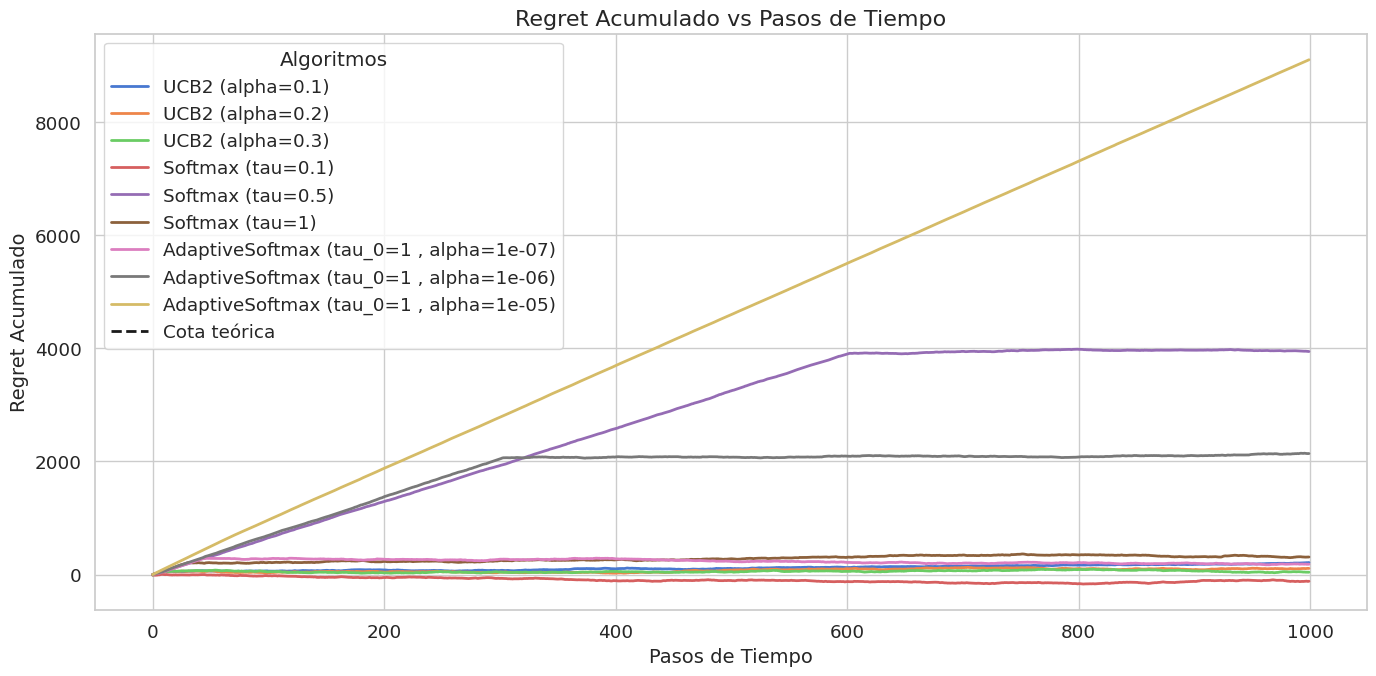

In [27]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

In [28]:
theoretical_bound

array([-inf,  nan,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  i

La cota teórica sale infinito, por lo que en cualquier caso, el regret acumulado obtenido por cualquiera de los algoritmos va a estar por debajo de esta cota.

## **[3] - Conclusiones de este estudio**

Mejores resultados según el estadístico seleccionado y según la distribución elegida para los brazos

| Distribución de los brazos | Porcentaje de elecciones de brazo óptimas en el último paso | Regret acumulado en el último paso |
|:---------:|:---------:|:---------:|
| Normal  | UCB2 ($\alpha=1.0$) , Softmax ($\tau=0.9$)  | UCB2 ($\alpha=1.0$) , Softmax ($\tau=0.2,0.3$)  |
| Bernoulli  | UCB2 ($\alpha=1.0$) , Softmax ($\tau=0.1$)  | UCB2 ($\alpha=1.0$) , Softmax ($\tau=0.1$)  |
| Binomial  | UCB2 ($\alpha=1.0$) , Softmax ($\tau=0.9$)   | UCB2 ($\alpha=1.0$) , Softmax ($\tau=0.1$)  |




Como conclusión podemos determinar que, sorprendentemente, al cambiar la distribución de los brazos del bandido, el algoritmo que mejor desempeño ofrece también cambia. Esto parece contraintuitivo, pero quizá se pueda deber a cuestiones relacionadas con la generación de números aleatorios dentro de las ejecuciones y no realmente a que efectivamente los cambios en la distribución expliquen cambios en el *mejor* algoritmo de acuerdo a los criterios considerados.

Como sugerencia para completar el estudio, podríamos realizar muchas ejecuciones de un mismo algoritmo sobre distintas distribuciones de bandido y analizar las estadísticas obtenidas para determinar si se estabilizan a largo plazo (entonces un cambio en la distribución no reportaría cambios en la selección de un mejor algoritmo) o si no.

Por otro lado, dada la estrecha relación a nivel teórico entre regret acumulado y porcentaje de selecciones de brazo óptimas, lo esperable es que al variar el criterio de bondad entre estas dos *métricas* los *mejores algoritmos* no cambien. Sin embargo, como ya comentamos anteriormente en detalle, el componente muestral del experimento explica que en la práctica se puedan dar regrets decrecientes en algunos tramos temporales, y por tanto, que a pesar de elegirse el brazo óptimo con más frecuencia que el resto, la recompensa esperada a nivel muestral quede algo lejada a la recompensa esperada teóricamente.